<a href="https://colab.research.google.com/github/tanatiem/BADS7105-CRM-Analytics/blob/main/Homework%2007%20-%20Product%20Recommendation/hw07-product-recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
!pip install umap-learn

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

%cd '/content/drive/MyDrive/BADS/7105 CRM/work/07 - Product Recommendation/'
%ls

/content/drive/MyDrive/BADS/7105 CRM/work/07 - Product Recommendation
'Customer Preference Survey.csv'   prep_customer_pref.csv
 item_sim.gexf                    'Product Recommendation.ipynb'
 plots/                            user-item-latent-space.png


In [195]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('/content/drive/MyDrive/fonts/K2D-Regular.ttf')
mpl.rc('font', family='K2D', size=12, weight=200)

# Data Cleansing

Skip this, after executing once.

In [ ]:
filename = 'Customer Preference Survey.csv'

df = pd.read_csv(filename)
print(df.shape)
df.head(10)

(46, 62)


,ประทับเวลา,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
0,"20/3/2021, 11:29:59",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"20/3/2021, 11:33:10",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,กล้วยทอด,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"20/3/2021, 11:53:45",ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย
3,"20/3/2021, 11:54:01",ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย
4,"20/3/2021, 11:54:05",เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย
5,"20/3/2021, 11:54:13",ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย
6,"20/3/2021, 11:54:18",ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,NaN,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย
7,"20/3/2021, 11:54:21",เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,NaN,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย
8,"20/3/2021, 11:54:34",ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เ

In [ ]:
# remove first 2 rows, drop timestamp
prep = df.iloc[2:,1:].reset_index(drop=True).rename_axis('student').copy()
prep.head()

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
student,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย
1,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย
2,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย
3,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย
4,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,NaN,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย


In [ ]:
# check unique values, and NaN
prep.melt()['value'].value_counts(dropna=False)

ไม่เคย    1642
เคย       1036
NaN          6
Name: value, dtype: int64

In [ ]:
prep[prep.isna().sum(axis=1) > 0].style.apply(lambda x: ["background-color: red" if v is np.nan else "" for v in x], axis=1)

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
student,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,nan,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย
5,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,nan,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย
7,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,nan,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,nan,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย
11,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,nan,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย
29,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,nan,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย


In [ ]:
# Impute na -> ไม่เคย
prep.fillna('ไม่เคย', inplace=True)
prep.isna().any().sum()

0

In [ ]:
prep.replace({'เคย': 1, 'ไม่เคย': 0}, inplace=True)
prep.head()

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
student,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,1,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,1,1,0,1,0,1
2,1,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,1,1,1
3,0,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,1


In [ ]:
prep[['เครื่องย่อยเศษอาหาร','เครื่องย่อยเศษอาหาร.1']].corr()

,เครื่องย่อยเศษอาหาร,เครื่องย่อยเศษอาหาร.1
เครื่องย่อยเศษอาหาร,1.0,1.0
เครื่องย่อยเศษอาหาร.1,1.0,1.0


In [ ]:
prep.drop('เครื่องย่อยเศษอาหาร.1',axis=1, inplace=True)
prep.rename({'เนื้อวากิล':'เนื้อวากิว'}, axis=1, inplace=True)
prep.to_csv('prep_customer_pref.csv')

# Load dataset

In [196]:
df = pd.read_csv('prep_customer_pref.csv', index_col=0)
print(df.shape)
df.head()

(44, 60)


,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิว,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
student,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1
1,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,1,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,1,1,0,1,0,1
2,1,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,1,1,1
3,0,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,1


# EDA

In [5]:
df.describe().T.sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
ครีมกันแดด,44.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
กระเป๋า,44.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
ชาบู,44.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
โรตี,44.0,0.954545,0.210707,0.0,1.0,1.0,1.00,1.0
กะหรี่(ปั๊บ),44.0,0.931818,0.254972,0.0,1.0,1.0,1.00,1.0
เม็ดมะม่วงหิมพานต์,44.0,0.909091,0.290803,0.0,1.0,1.0,1.00,1.0
หมอนข้าง,44.0,0.863636,0.347142,0.0,1.0,1.0,1.00,1.0
แฟน ที่แปลว่าพัดลม,44.0,0.818182,0.390154,0.0,1.0,1.0,1.00,1.0
หมูแดดเดียว,44.0,0.795455,0.408032,0.0,1.0,1.0,1.00,1.0
Software ถูกลิขสิทธิ์,44.0,0.772727,0.423915,0.0,1.0,1.0,1.00,1.0


## Purchase/Usage Ranking

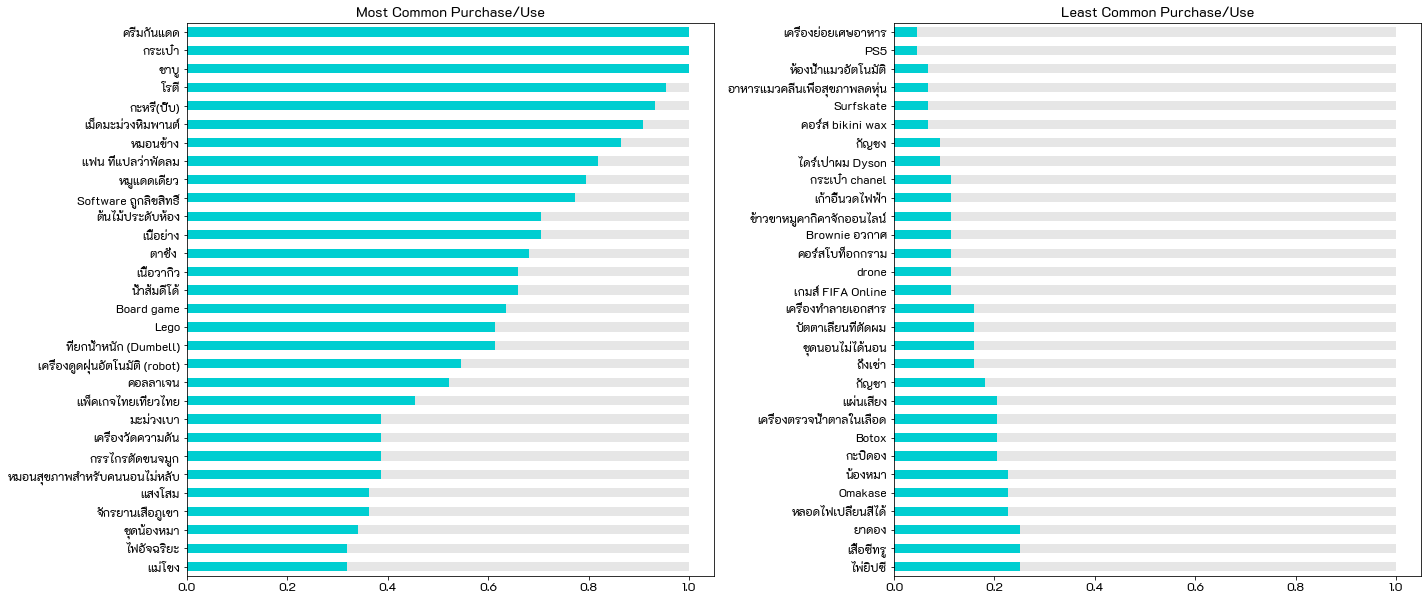

In [6]:
temp = df.mean().sort_values().to_frame().rename({0:'yes'}, axis=1)
temp['no'] = 1 - temp['yes']

fig, axes = plt.subplots(1,2, figsize=(20,8.5), tight_layout=True)
colors = ['darkturquoise','.9']
temp[30:].plot.barh(stacked=True, color=colors, ax=axes[0], title='Most Common Purchase/Use', legend=False)
temp[:30].sort_values('yes', ascending=False).plot.barh(stacked=True, color=colors, ax=axes[1], title='Least Common Purchase/Use', legend=False)
# plt.savefig('plots/usage.png',dpi=120)
plt.show()

Most popular items can be served a simple recommendation for users without any historical data.

## Item Count per User

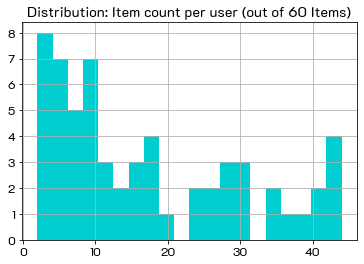

In [8]:
df.sum().hist(bins=20, color='darkturquoise')
plt.title('Distribution: Item count per user (out of 60 Items)')
plt.show()

# Market Basket Analysis

## Frequent Itemsets & Association Rules

In [243]:
# calculate frequent itemsets
frequent_itemsets = apriori(df, min_support=0.5, use_colnames=True)
print(frequent_itemsets.shape)
frequent_itemsets.head()

(5247, 2)


,support,itemsets
0,0.522727,(คอลลาเจน)
1,0.704545,(ต้นไม้ประดับห้อง)
2,0.863636,(หมอนข้าง)
3,0.681818,(ตาชั่ง )
4,0.931818,(กะหรี่(ปั๊บ))


In [244]:
# generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
print(rules.shape)
rules.sort_values('lift',ascending=False).head(15)

(322280, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
260388,"(เม็ดมะม่วงหิมพานต์, เนื้อวากิว, กระเป๋า, หมอน...","(หมูแดดเดียว, โรตี, เนื้อย่าง, ชาบู)",0.568182,0.613636,0.522727,0.920000,1.499259,0.17407,4.829545
308414,"(หมูแดดเดียว, กระเป๋า, เนื้อย่าง)","(หมอนข้าง, โรตี, ครีมกันแดด, ชาบู, เม็ดมะม่วงห...",0.613636,0.568182,0.522727,0.851852,1.499259,0.17407,2.914773
261151,"(หมูแดดเดียว, โรตี, เนื้อย่าง, ครีมกันแดด)","(เม็ดมะม่วงหิมพานต์, เนื้อวากิว, กระเป๋า, หมอน...",0.613636,0.568182,0.522727,0.851852,1.499259,0.17407,2.914773
308021,"(หมอนข้าง, โรตี, ครีมกันแดด, ชาบู, เม็ดมะม่วงห...","(หมูแดดเดียว, เนื้อย่าง)",0.568182,0.613636,0.522727,0.920000,1.499259,0.17407,4.829545
308404,"(หมูแดดเดียว, โรตี, เนื้อย่าง)","(เนื้อวากิว, หมอนข้าง, ครีมกันแดด, ชาบู, เม็ดม...",0.613636,0.568182,0.522727,0.851852,1.499259,0.17407,2.914773
89327,"(เม็ดมะม่วงหิมพานต์, เนื้อวากิว, หมอนข้าง)","(หมูแดดเดียว, ครีมกันแดด, เนื้อย่าง)",0.568182,0.613636,0.522727,0.920000,1.499259,0.17407,4.829545
308408,"(หมูแดดเดียว, ครีมกันแดด, เนื้อย่าง)","(เนื้อวากิว, หมอนข้าง, โรตี, ชาบู, เม็ดมะม่วงห...",0.613636,0.568182,0.522727,0.851852,1.499259,0.17407,2.914773
176674,"(เนื้อวากิว, หมอนข้าง, ครีมกันแดด, เม็ดมะม่วงห...","(หมูแดดเดียว, เนื้อย่าง)",0.568182,0.613636,0.522727,0.920000,1.499259,0.17407,4.829545
308412,"(หมูแดดเดียว, เนื้อย่าง, ชาบู)","(เนื้อวากิว, หมอนข้าง, โรตี, ครีมกันแดด, เม็ดม...",0.613636,0.568182,0.522727,0.851852,1.499259,0.17407,2.914773
260466,"(หมูแดดเดียว, กระเป๋า, เนื้อย่าง)","(เนื้อวากิว, หมอนข้าง, โรตี, ชาบู, เม็ดมะม่วงห...",0.613636,0.568182,0.522727,0.851852,1.499259,0.17407,2.914773


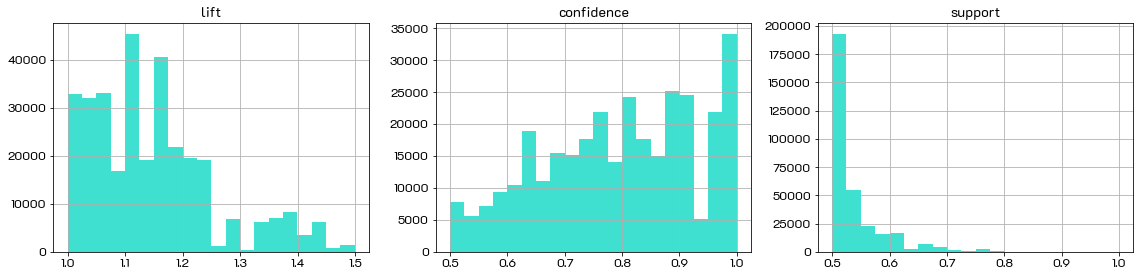

In [245]:
fig, axes = plt.subplots(1, 3, figsize=(16,4), tight_layout=True)
for var, ax in zip(['lift','confidence','support'], axes):
    rules[var].hist(bins=20, ax=ax, color='turquoise')
    ax.set_title(var)
plt.show()

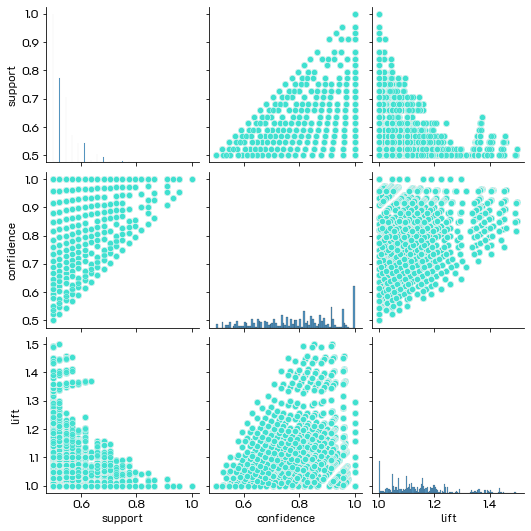

In [246]:
sns.pairplot(rules, vars=['support','confidence','lift'], plot_kws = {'color':'turquoise', 'alpha':.5});

## Visualize Rules of 1-Itemsets

Both cardinalities of antecedent and consequent sets = 1

In [247]:
simple_rules = rules[(rules['antecedents'].apply(len) == 1) & (rules['consequents'].apply(len) == 1) & (rules['lift'] > 1.05) & (rules['confidence'] > 0.5)]
print(simple_rules.shape)
simple_rules.sort_values('lift', ascending=False).head(20)

(50, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
156,(เนื้อวากิว),(เนื้อย่าง),0.659091,0.704545,0.636364,0.965517,1.370412,0.172004,8.568182
157,(เนื้อย่าง),(เนื้อวากิว),0.704545,0.659091,0.636364,0.903226,1.370412,0.172004,3.522727
16,(Lego),(ต้นไม้ประดับห้อง),0.613636,0.704545,0.522727,0.851852,1.209080,0.090393,1.994318
17,(ต้นไม้ประดับห้อง),(Lego),0.704545,0.613636,0.522727,0.741935,1.209080,0.090393,1.497159
98,(Lego),(เนื้อย่าง),0.613636,0.704545,0.500000,0.814815,1.156511,0.067665,1.595455
99,(เนื้อย่าง),(Lego),0.704545,0.613636,0.500000,0.709677,1.156511,0.067665,1.330808
155,(เนื้อวากิว),(หมูแดดเดียว),0.659091,0.795455,0.590909,0.896552,1.127094,0.066632,1.977273
154,(หมูแดดเดียว),(เนื้อวากิว),0.795455,0.659091,0.590909,0.742857,1.127094,0.066632,1.325758
167,(Software ถูกลิขสิทธิ์),(เนื้อวากิว),0.772727,0.659091,0.568182,0.735294,1.115619,0.058884,1.287879
166,(เนื้อวากิว),(Software ถูกลิขสิทธิ์),0.659091,0.772727,0.568182,0.862069,1.115619,0.058884,1.647727


In [248]:
edgelist = []
for i,x in simple_rules.iterrows():
    n1, = x['antecedents']
    n2, = x['consequents']
    attr = { 'lift': round(x['lift'],4), 'confidence' : round(x['confidence'],4) }
    edgelist.append((n1,n2,attr))

nodes = { n1 for n1, n2, attr in edgelist}.union({ n2 for n1, n2, attr in edgelist})

support_df = frequent_itemsets[frequent_itemsets['itemsets'].apply(len)==1].copy()
support_df['item'] = support_df['itemsets'].apply(lambda x: list(x)[0])
support_df = support_df[support_df['item'].isin(nodes)]

nodelist = []
for i,x in support_df.iterrows():
    n = x['item']
    attr = { 'support' : round(x['support'],4) }
    nodelist.append((n, attr))

# create graph
G = nx.DiGraph()

G.add_nodes_from(nodelist)
G.add_edges_from(edgelist)

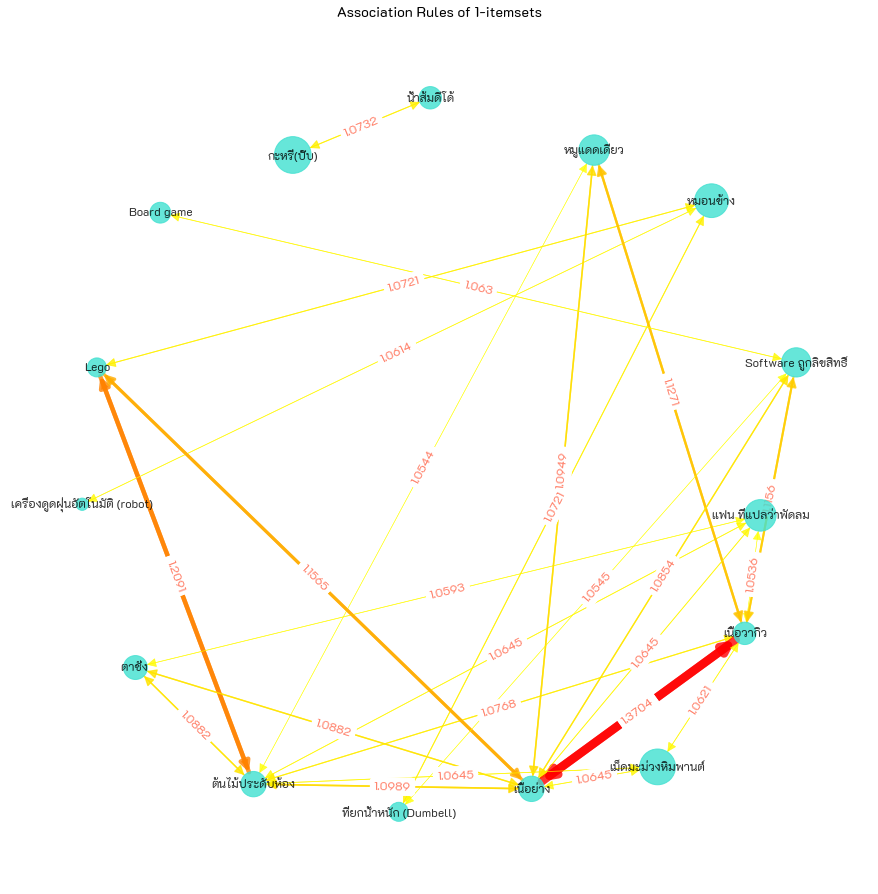

In [251]:
nodelist, node_size = zip(*[(n,d['support']) for n,d in G.nodes(data=True)])
node_size = 150 + ((np.array(node_size) - min(node_size)) / (max(node_size) - min(node_size)))*1200
edgelist, width = zip(*[((u,v), d['lift'])for u,v,d in G.edges(data=True)])

width = .5 + ((np.array(width) - min(width)) / (max(width) - min(width)))*8

labels_params = {'font_family': 'K2D', 'alpha':.8, 'font_size':12}

plt.figure(figsize=(12,12))

# pos = nx.spring_layout(G, k=5, weight='lift', iterations=120, seed=120, scale=2.5)
pos = nx.spring_layout(G, k=5, weight='lift', iterations=80, seed=90, scale=2.5)
nx.draw(G, pos, with_labels=True, arrowsize=20, 
        edgelist=edgelist, width=width, edge_color=width, edge_cmap=plt.cm.autumn_r, #edge_color='.75',
        nodelist=nodelist, node_size=node_size, node_color='turquoise', 
        **labels_params)
edge_labels = nx.get_edge_attributes(G, 'lift')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='tomato',  **labels_params)

plt.title('Association Rules of 1-itemsets')
# plt.savefig('plots/association-rules-1.jpg', dpi=120)
plt.show()

## Explore Rules

In [29]:
# Recommend 1 item based on 2 items
rules[(rules['antecedents'].apply(len) == 2) & (rules['consequents'].apply(len) == 1)].sort_values('lift', ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2199,"(หมูแดดเดียว, เนื้อย่าง)",(เนื้อวากิว),0.613636,0.659091,0.568182,0.925926,1.404853,0.163740,4.602273
2266,"(Software ถูกลิขสิทธิ์, เนื้อย่าง)",(เนื้อวากิว),0.590909,0.659091,0.545455,0.923077,1.400531,0.155992,4.431818
2248,"(เนื้อวากิว, ชาบู)",(เนื้อย่าง),0.659091,0.704545,0.636364,0.965517,1.370412,0.172004,8.568182
2241,"(กระเป๋า, เนื้อย่าง)",(เนื้อวากิว),0.704545,0.659091,0.636364,0.903226,1.370412,0.172004,3.522727
2271,"(ครีมกันแดด, เนื้อย่าง)",(เนื้อวากิว),0.704545,0.659091,0.636364,0.903226,1.370412,0.172004,3.522727
2270,"(ครีมกันแดด, เนื้อวากิว)",(เนื้อย่าง),0.659091,0.704545,0.636364,0.965517,1.370412,0.172004,8.568182
2259,"(โรตี, เนื้อย่าง)",(เนื้อวากิว),0.704545,0.659091,0.636364,0.903226,1.370412,0.172004,3.522727
2258,"(โรตี, เนื้อวากิว)",(เนื้อย่าง),0.659091,0.704545,0.636364,0.965517,1.370412,0.172004,8.568182
2240,"(กระเป๋า, เนื้อวากิว)",(เนื้อย่าง),0.659091,0.704545,0.636364,0.965517,1.370412,0.172004,8.568182
2247,"(ชาบู, เนื้อย่าง)",(เนื้อวากิว),0.704545,0.659091,0.636364,0.903226,1.370412,0.172004,3.522727


In [32]:
# Recommend 1 item based on 3 items
rules[(rules['antecedents'].apply(len) == 3) & (rules['consequents'].apply(len) == 1)].sort_values('lift', ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13537,"(ชาบู, หมูแดดเดียว, เนื้อย่าง)",(เนื้อวากิว),0.613636,0.659091,0.568182,0.925926,1.404853,0.163740,4.602273
13565,"(โรตี, หมูแดดเดียว, เนื้อย่าง)",(เนื้อวากิว),0.613636,0.659091,0.568182,0.925926,1.404853,0.163740,4.602273
13523,"(กระเป๋า, หมูแดดเดียว, เนื้อย่าง)",(เนื้อวากิว),0.613636,0.659091,0.568182,0.925926,1.404853,0.163740,4.602273
13552,"(หมูแดดเดียว, เนื้อย่าง, เม็ดมะม่วงหิมพานต์)",(เนื้อวากิว),0.613636,0.659091,0.568182,0.925926,1.404853,0.163740,4.602273
13579,"(ครีมกันแดด, หมูแดดเดียว, เนื้อย่าง)",(เนื้อวากิว),0.613636,0.659091,0.568182,0.925926,1.404853,0.163740,4.602273
13972,"(โรตี, Software ถูกลิขสิทธิ์, เนื้อย่าง)",(เนื้อวากิว),0.590909,0.659091,0.545455,0.923077,1.400531,0.155992,4.431818
10102,"(หมูแดดเดียว, เนื้อย่าง, กะหรี่(ปั๊บ))",(เนื้อวากิว),0.590909,0.659091,0.545455,0.923077,1.400531,0.155992,4.431818
13903,"(ชาบู, Software ถูกลิขสิทธิ์, เนื้อย่าง)",(เนื้อวากิว),0.590909,0.659091,0.545455,0.923077,1.400531,0.155992,4.431818
14000,"(ครีมกันแดด, Software ถูกลิขสิทธิ์, เนื้อย่าง)",(เนื้อวากิว),0.590909,0.659091,0.545455,0.923077,1.400531,0.155992,4.431818
13846,"(กระเป๋า, Software ถูกลิขสิทธิ์, เนื้อย่าง)",(เนื้อวากิว),0.590909,0.659091,0.545455,0.923077,1.400531,0.155992,4.431818


# Collaborative Filtering - Item Similarity



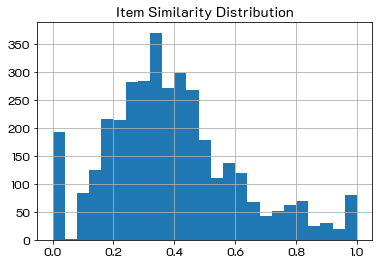

In [52]:
X = df.T
item_names = df.columns
item_sim = cosine_similarity(X)
item_sim = pd.DataFrame(item_sim, index=item_names, columns=item_names)
item_sim = item_sim.unstack().reset_index()
item_sim.columns = ['item1','item2','sim']
item_sim['sim'].hist(bins=25)
plt.title('Item Similarity Distribution');

In [47]:
sim_threshold = 0.65
sim_df = item_sim[item_sim.apply(lambda x: x['item1']!=x['item2'], axis=1) & item_sim['sim'].between(sim_threshold, 1)]
sim_df.sort_values('sim', ascending=False)

,item1,item2,sim
1919,กระเป๋า,ครีมกันแดด,1.00000
1892,กระเป๋า,ชาบู,1.00000
1951,ชาบู,กระเป๋า,1.00000
3571,ครีมกันแดด,กระเป๋า,1.00000
3572,ครีมกันแดด,ชาบู,1.00000
...,...,...,...
1782,เนื้อย่าง,กรรไกรตัดขนจมูก,0.65341
2270,เม็ดมะม่วงหิมพานต์,มะม่วงเบา,0.65192
2275,เม็ดมะม่วงหิมพานต์,หมอนสุขภาพสำหรับคนนอนไม่หลับ,0.65192
3037,มะม่วงเบา,เม็ดมะม่วงหิมพานต์,0.65192


Name: 
Type: Graph
Number of nodes: 42
Number of edges: 187
Average degree:   8.9048


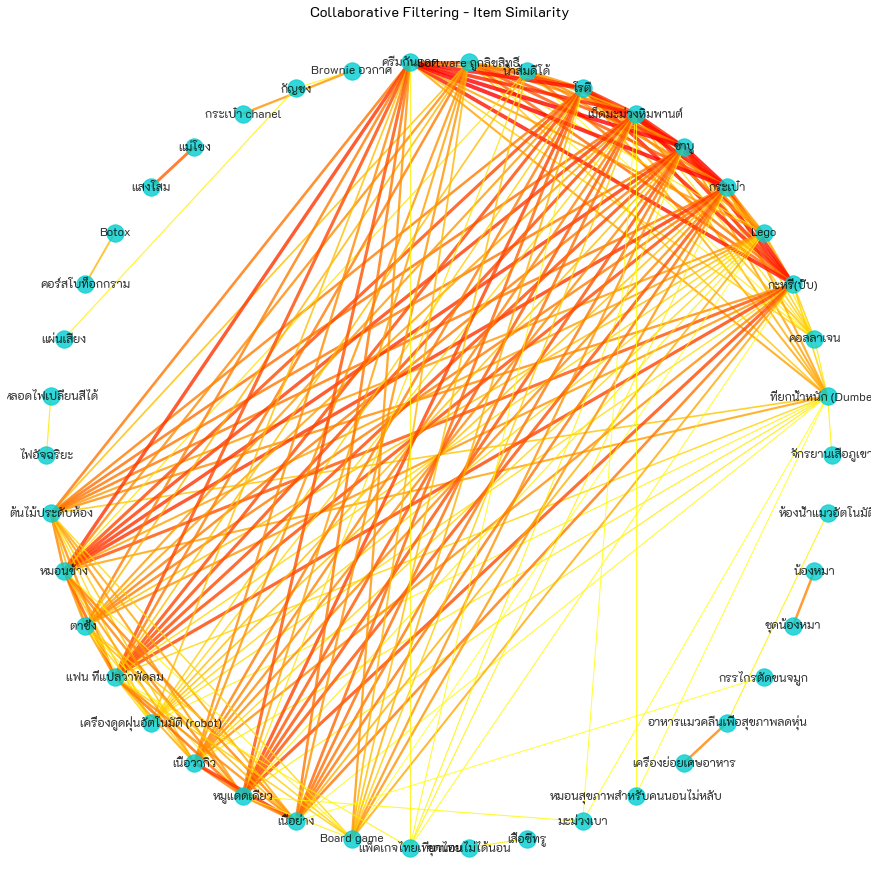

In [48]:
G = nx.Graph()
G.add_weighted_edges_from([ (x['item1'],x['item2'], round(x['sim'],2)) for i,x in sim_df.iterrows()])
print(nx.info(G))
labels_params = {'font_family': 'K2D', 'alpha':.8, 'font_size':12}

edgelist, weights = zip(*[((u,v), d['weight'])for u,v,d in G.edges(data=True)])
width = 1 + ((np.array(weights) - min(weights)) / (max(weights) - min(weights)))*3

plt.figure(figsize=(12,12))
pos = nx.circular_layout(G, scale=5)
nx.draw(G, pos, with_labels=True, node_color='darkturquoise', 
        edgelist=edgelist, width=width, 
        edge_color=weights, edge_cmap=plt.cm.autumn_r,
        **labels_params)
plt.title('Collaborative Filtering - Item Similarity')
# plt.savefig('./plots/item_sim.png', dpi=120)
plt.show()

In [7]:
# nx.write_gexf(G, 'item_sim.gexf')

# Matrix Factorization

Try Non-Matrix Factorization

In [197]:
from sklearn.decomposition import NMF

# X = df.drop(['ครีมกันแดด','กระเป๋า','ชาบู'],axis=1) # remove items that all users use
X = df
n_factors = 12

nmf = NMF(n_factors, random_state=48)
W = nmf.fit_transform(X)
H = nmf.components_
print(f'Reconstruction error: {nmf.reconstruction_err_}')

# reconstruct rating matrix -> recommendation 
rec_df = pd.DataFrame(W @ H, columns=X.columns, index=X.index)
rec_df.head()

Reconstruction error: 12.826537391493936


,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิว,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
student,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.363374,0.211746,0.030898,0.039321,0.020598,0.079314,0.018937,0.008863,0.049964,0.050833,0.051755,0.140729,0.619445,0.592279,0.015019,0.036064,1.066422,0.749651,0.799175,0.146178,0.003160,0.048634,0.771848,1.058769,0.847154,0.049218,0.003555,0.066411,0.007041,1.300109,0.014963,0.985740,0.985740,0.020630,1.027321,0.056633,0.946909,0.780659,0.084642,0.128639,0.080105,0.126039,1.109732,0.191251,0.000245,1.004354,0.009850,0.038612,0.107795,0.225792,0.028896,0.008807,0.003248,0.006472,0.001479,0.020866,0.011838,1.095603,0.759926,0.985740
1,0.379209,0.649541,0.101199,0.882868,0.018276,0.110679,0.002588,0.697901,0.173646,0.474268,0.047574,0.645111,1.047489,0.844647,0.167155,0.999568,1.062993,0.201588,0.808520,0.002157,0.945619,0.869783,0.665207,0.256995,0.998837,0.044637,0.005743,0.975266,0.847231,0.253022,0.048118,1.056165,1.056165,0.049903,0.107713,0.035560,0.040469,1.128401,0.222461,0.009423,0.044332,0.055463,0.653419,0.000694,0.580269,0.851108,0.679364,0.223314,1.235281,0.115052,1.268238,0.091288,0.118206,0.194883,0.898258,1.081669,0.007514,0.849659,0.084908,1.056165
2,0.666513,0.703320,0.080205,0.077268,0.000000,0.109814,0.103789,0.920301,0.791137,0.359149,0.095730,1.107764,0.986420,1.131998,0.126577,0.033049,0.931857,0.913774,0.771884,0.132364,0.648501,0.963886,0.761354,1.037454,1.040088,0.208341,0.098270,0.833896,0.515614,0.966700,0.533121,1.001854,1.001854,0.336392,1.012895,0.948272,0.051131,0.867928,1.145601,0.183910,0.196289,0.097509,0.354364,0.014900,0.996888,1.103292,0.197034,0.838448,0.102505,0.043346,0.691286,0.004707,0.062570,0.136041,0.065774,0.926417,0.089845,0.886162,1.193357,1.001854
3,0.280046,0.028946,0.263271,0.883870,0.000000,0.737050,0.121279,0.363686,0.053162,0.040936,0.452840,1.162489,0.983451,0.444527,0.000000,1.002267,0.908481,1.284336,0.874272,1.110339,0.001203,0.141269,0.903045,0.917328,1.063005,0.344298,0.000000,0.009893,0.012380,1.059835,0.004566,0.973912,0.973912,0.167750,0.951613,0.001412,0.889147,0.961456,0.037589,0.322242,0.022822,0.287102,1.161505,0.121592,0.000000,0.974133,0.000000,0.000000,0.459419,0.623207,0.011721,0.043854,0.000000,0.009288,0.000000,0.144593,0.012731,0.197297,0.254758,0.973912
4,0.227145,1.130259,0.152704,0.108364,0.845054,0.106403,0.103353,0.108037,0.215019,0.107549,0.056447,0.596148,0.588170,0.501623,0.581159,0.084016,1.005182,0.604311,0.932622,0.363993,0.240101,0.697401,0.211309,0.151235,0.598349,0.136482,0.136956,0.522724,0.199448,0.211801,0.260411,1.014899,1.014899,0.039983,0.777275,1.015781,0.128957,0.818784,0.103194,0.188468,0.181241,0.292050,0.160385,0.106749,0.132439,0.993231,0.131177,0.701273,0.336468,0.017000,0.161324,0.101421,0.272476,0.111530,0.018832,0.627045,0.154121,1.052161,1.098089,1.014899


In [198]:
rating_df = df.reset_index().melt(id_vars='student') \
    .merge(rec_df.reset_index().melt(id_vars='student'), left_on=['student','variable'], right_on=['student','variable']) \
    .rename({'variable':'item', 'value_x' : 'r', 'value_y' : 'r_pred' }, axis=1) 
rating_df

,student,item,r,r_pred
0,0,จักรยานเสือภูเขา,0,0.363374
1,1,จักรยานเสือภูเขา,0,0.379209
2,2,จักรยานเสือภูเขา,1,0.666513
3,3,จักรยานเสือภูเขา,0,0.280046
4,4,จักรยานเสือภูเขา,0,0.227145
...,...,...,...,...
2635,39,ครีมกันแดด,1,1.058292
2636,40,ครีมกันแดด,1,0.964681
2637,41,ครีมกันแดด,1,0.876630
2638,42,ครีมกันแดด,1,1.200926


## Recommended item for each user

In [199]:
# recommendation is the not-purchased items with the highest predicted rating
rec_items = rating_df[rating_df['r']==0].sort_values(['student','r_pred'], ascending=False).groupby('student').nth(0)
rec_items

,item,r,r_pred
student,,,
0,ตาชั่ง,0,0.592279
1,ต้นไม้ประดับห้อง,0,0.645111
2,เครื่องดูดฝุ่นอัตโนมัติ (robot),0,0.761354
3,แพ็คเกจไทยเที่ยวไทย,0,0.459419
4,Lego,0,0.604311
5,Omakase,0,0.519264
6,ตาชั่ง,0,0.633394
7,แม่โขง,0,0.672528
8,หลอดไฟเปลี่ยนสีได้,0,0.588435


In [210]:
import umap

temp = pd.DataFrame(np.vstack([W, H.T]))
temp.shape

reducer = umap.UMAP()
embed = reducer.fit_transform(temp)
embed.shape

(104, 2)

In [211]:
latent_df = pd.DataFrame(embed, columns=['x','y'])
latent_df['type'] = ['user'] * W.shape[0] + ['item'] * H.shape[1]
latent_df['label'] = list(X.index) + list(X.columns)
latent_df

,x,y,type,label
0,8.516644,2.816948,user,0
1,9.798666,3.100168,user,1
2,10.271331,1.887925,user,2
3,12.035024,1.799204,user,3
4,8.727072,3.363702,user,4
...,...,...,...,...
99,10.174990,2.913331,item,หมอนสุขภาพสำหรับคนนอนไม่หลับ
100,11.543087,3.270145,item,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น
101,7.852885,2.580426,item,น้ำส้มดีโด้
102,6.286385,0.126586,item,Software ถูกลิขสิทธิ์


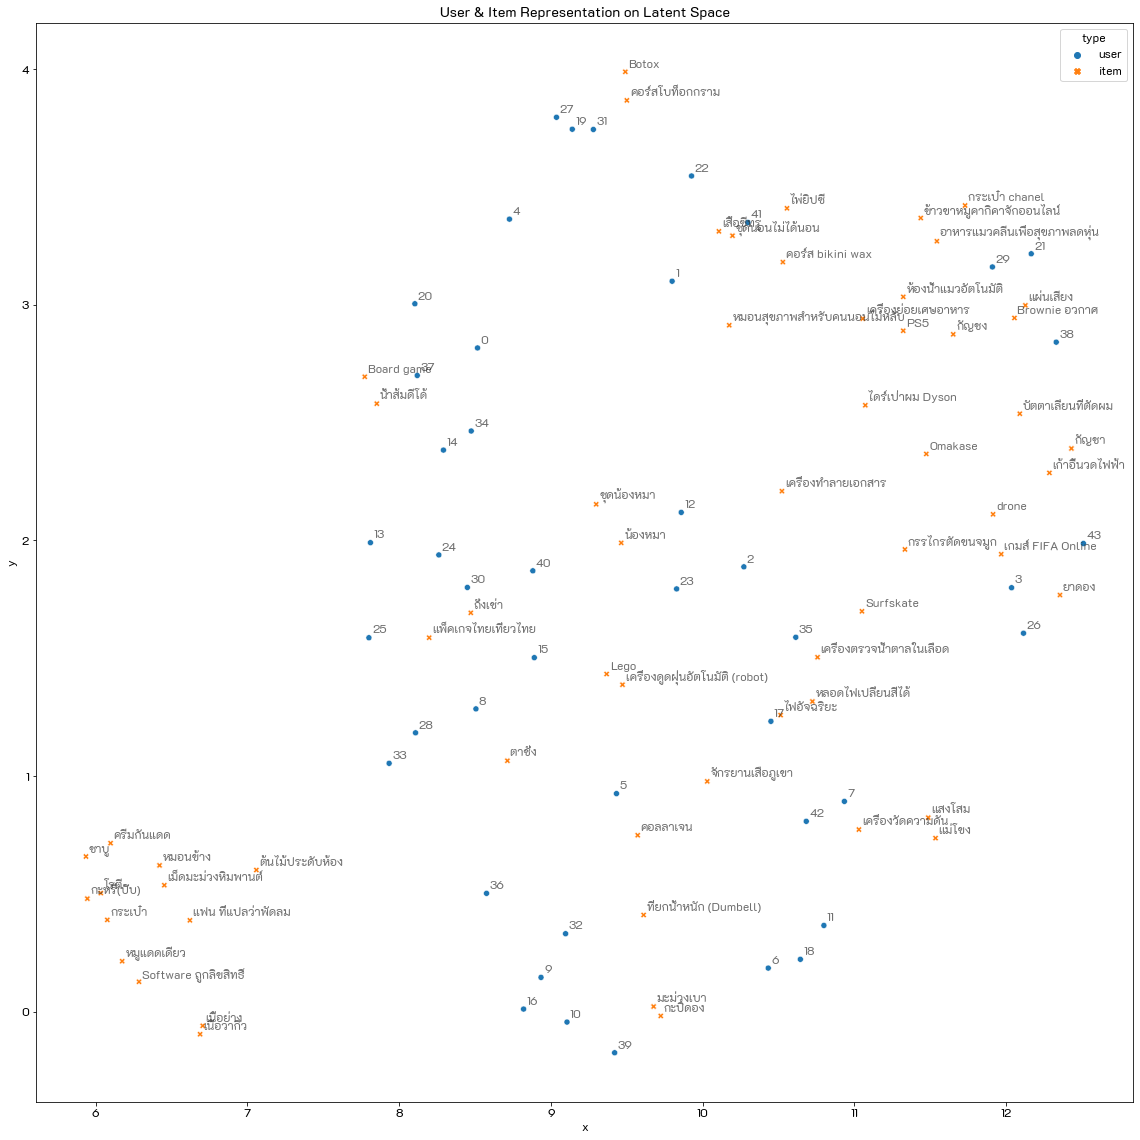

In [213]:
plt.figure(figsize=(16,16), tight_layout=True)
sns.scatterplot(x='x', y='y', hue='type', data=latent_df, style='type')
for i,r in latent_df.iterrows():
    px, py, text = r['x'], r['y'], r['label']
    plt.annotate(text, (px+.02,py+.02), color='.2', alpha=.7)
plt.title('User & Item Representation on Latent Space')
plt.savefig('./plots/user-item-latent-space.png', dpi=120)
plt.show()